In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.layers import Input
import numpy as np
import os
#import Pillow
#from PIL import Image
#import opencv
from PIL import Image
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
from keras.preprocessing.image

num_train = 2000              # 訓練データの画像数
num_validation = 800          # テストデータの画像数
img_h, img_w = 150, 150       # 画像のサイズ
channels = 3                  # チャンネル数
batch_size = 32               # ミニバッチのサイズ
train_data_dir = 'data/train' # 訓練データのフォルダー
validation_data_dir = 'data/validation' # テストデータのフォルダー
result_dir = 'results'        # VGG16の出力結果を保存するフォルダー

# resultsフォルダーが存在しなければ作成
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

    
def save_VGG16_outputs():
    '''
    VGG16にDog vs Catの訓練データ、テストデータを入力し、
    出力結果をnpyファイルに保存する
    
　　'''  
    # VGG16モデルと学習済み重みを読み込む
    model = VGG16(
        include_top=False,            # 全結合層は層（FC）は読み込まない
        weights='imagenet',           # ImageNetで学習した重みを利用
        input_shape=(img_h, img_w, channels) # 入力データの形状
    )
    
    # サマリを表示
    model.summary()

    # 訓練データとテストデータを読み込むジェネレーターを生成
    datagen = ImageDataGenerator(rescale=1.0 / 255)
    # Dog vs Catの訓練データを生成するするジェネレーター
    train_generator = datagen.flow_from_directory(
        train_data_dir,               # 訓練データのフォルダー
        target_size=(img_w, img_h),   # 画像をリサイズ
        batch_size=batch_size,        # ミニバッチのサイズ
        class_mode=None,              # 出力層は存在しないのでclass_modeはNone
        shuffle=False)                # データをシャッフルしない
    # テストデータの正解ラベルを出力
    print('train-label:',train_generator.class_indices) 
    # 訓練データをVGG16モデルに入力し、その出力をファイルに保存
    vgg16_train = model.predict_generator(
        train_generator,              # ジェネレーター
        steps = len(train_generator), # ジェネレーターのサイズを設定
        verbose=1                     # 進捗状況を出力
    )
    # 訓練データの出力を保存
    np.save(os.path.join(result_dir, 'vgg16_train.npy'),
            vgg16_train)

    # Dog vs Catのテストデータを生成するジェネレーター
    validation_generator = datagen.flow_from_directory(
        validation_data_dir,          # テストデータのフォルダー
        target_size=(img_w, img_h),   # 画像をリサイズ
        batch_size=batch_size,        # ミニバッチのサイズ
        class_mode=None,              # 出力層は存在しないのでclass_modeはNone
        shuffle=False)                # データをシャッフルしない
    
    
    # テストデータの正解ラベルを出力
    print('test-label:',validation_generator.class_indices)
    
    
    # テストデーターをVGG16モデルに入力する
    vgg16_test = model.predict_generator(
        validation_generator,              # ジェネレーター
        steps = len(validation_generator), # ジェネレーターのサイズを設定
        verbose=1                          # 進捗状況を出力
    )
    
    
    # テストデータの出力を保存
    np.save(os.path.join(result_dir, 'vgg16_test.npy'),
            vgg16_test)

Using TensorFlow backend.


In [2]:
save_VGG16_outputs()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [2]:
1000 / 2


500.0

In [4]:
import os
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation, Dropout, Flatten, Dense

def train_FClayer():
    '''
    VGG16の出力を入力し、FCネットワークで学習する
    
    '''
    # 訓練データのVGG16からの出力を読み込む
    train_data = np.load(
        os.path.join(result_dir, 'vgg16_train.npy'))    
    # VGG16の訓練データの形状を出力
    print(train_data.shape)    
    # 正解ラベルの作成 最初の2000枚が0(cat),次の2000枚が1(dag)
    train_labels = np.array(
        [0] * int(num_train / 2) + [1] * int(num_train / 2)
    )

    # テストデータのVGG16からの出力を読み込む
    validation_data = np.load(
        os.path.join(result_dir, 'vgg16_test.npy'))
    # VGG16のテストデータの形状を出力
    print(validation_data.shape)    
    # 正解ラベルを作成
    # ネコが0、イヌが1
    # 最初の800枚(cat)に0、次の800枚(dog)に1を割り当てる
    validation_labels = np.array(
        [0] * int(num_validation / 2) + [1] * int(num_validation / 2)
    )

    # FCネットワークの作成
    model = Sequential()
    # Flatten　全結合層への入力を4階テンソルから2階テンソルに変換する
    model.add(Flatten(input_shape=train_data.shape[1:]))
    # 全結合層
    model.add(Dense(256,                   # ニューロン数は256
                    activation='relu'))    # 活性化関数はReLU
    model.add(Dropout(0.5))                # ドロップアウト50％
    # 出力層
    model.add(Dense(1,                     # ニューロン数は256
                    activation='sigmoid')) # 活性化関数はReLU

    # モデルのコンパイル
    model.compile(
        loss='binary_crossentropy',        # バイナリ用の交差エントロピー誤差
        metrics=['accuracy'],              # 学習評価として正解率を指定
        # 確率的勾配降下法で最適化 学習率0.0001
        # 慣性項(Momentum)を0.9にして前回の更新量に0.9倍して加算することで
        # パラメータの更新を慣性的なものにする
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    )

    # 学習の実行
    epoch = 60                             # 学習回数
    batch_size = 32                        # ミニバッチのサイズ
    history = model.fit(train_data,        # 訓練データ
                        train_labels,      # 訓練データの正解ラベル
                        epochs=epoch,      # 学習回数
                        batch_size=batch_size,
                        verbose=1,
                        # テストデータと正解ラベル
                        validation_data=(validation_data,
                                         validation_labels)
                        )
    
    # 学習結果の保存
    with open('model.json', 'w') as json_file:
        json_file.write(model.to_json())
    model.save_weights('weight.h5')

    # historyを返す
    return history


In [5]:
# VGG16の出力をFCネットワークで学習
history = train_FClayer()

(2000, 4, 4, 512)
(800, 4, 4, 512)
Train on 2000 samples, validate on 800 samples
Epoch 1/60
2000/2000 [==============================] - 1s 469us/step - loss: 0.7462 - accuracy: 0.5335 - val_loss: 0.5965 - val_accuracy: 0.7150
Epoch 2/60
2000/2000 [==============================] - 1s 408us/step - loss: 0.5920 - accuracy: 0.6775 - val_loss: 0.5281 - val_accuracy: 0.8000
Epoch 3/60
2000/2000 [==============================] - 1s 403us/step - loss: 0.5339 - accuracy: 0.7355 - val_loss: 0.4904 - val_accuracy: 0.8163
Epoch 4/60
2000/2000 [==============================] - 1s 408us/step - loss: 0.5005 - accuracy: 0.7590 - val_loss: 0.4628 - val_accuracy: 0.8275
Epoch 5/60
2000/2000 [==============================] - 1s 406us/step - loss: 0.4726 - accuracy: 0.7880 - val_loss: 0.4400 - val_accuracy: 0.8363
Epoch 6/60
2000/2000 [==============================] - 1s 400us/step - loss: 0.4530 - accuracy: 0.8025 - val_loss: 0.4212 - val_accuracy: 0.8425
Epoch 7/60
2000/2000 [====================

In [9]:
type(history)
history.history

{'val_loss': [0.5964720892906189,
  0.528095554113388,
  0.4903604483604431,
  0.4628378164768219,
  0.43996414184570315,
  0.4212276566028595,
  0.4066667973995209,
  0.39250322699546814,
  0.3847876960039139,
  0.3702836525440216,
  0.36238898992538454,
  0.3556026792526245,
  0.34755451083183286,
  0.3449581742286682,
  0.3368866240978241,
  0.33381281793117523,
  0.328712654709816,
  0.3287074238061905,
  0.32109795093536375,
  0.31475110590457916,
  0.30954585790634154,
  0.30741912364959717,
  0.30533028542995455,
  0.3021657282114029,
  0.2996568512916565,
  0.2958667433261871,
  0.2942195439338684,
  0.30788257777690886,
  0.2908347648382187,
  0.2896408939361572,
  0.28795458018779757,
  0.28521288096904757,
  0.28470313012599946,
  0.2815971124172211,
  0.287354941368103,
  0.2789727348089218,
  0.2816287189722061,
  0.27848699271678923,
  0.273467658162117,
  0.27421831667423247,
  0.2738524180650711,
  0.27095012962818144,
  0.26847497999668124,
  0.26703385531902313,
  0.2

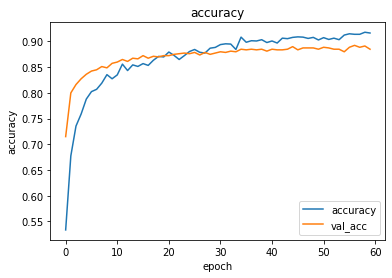

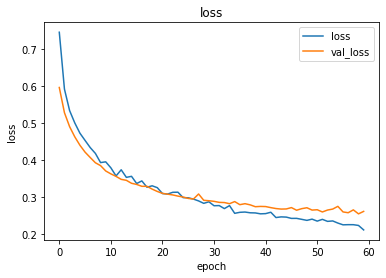

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_acc")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
# 損失と精度をグラフに出力
plot_acc_loss(history)